**Data** : **eighty-years-of-canadian-climate-data/Canadian_climate_history.csv**

In [18]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_file = ""
MODEL_SELECTED = "deepant" # Possible Values ['deepant', 'lstmae']
LOOKBACK_SIZE = 10
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_file = os.path.join(dirname, filename)

In [19]:
def read_modulate_data(data_file):
    """
        Data ingestion : Function to read and formulate the data
    """
    data = pd.read_csv(data_file)
    data.fillna(data.mean(), inplace=True)
    df = data.copy()
    data.set_index("LOCAL_DATE", inplace=True)
    data.index = pd.to_datetime(data.index)
    return data, df

In [20]:
def data_pre_processing(df):
    """
        Data pre-processing : Function to create data for Model
    """
    try:
        scaled_data = MinMaxScaler(feature_range = (0, 1))
        data_scaled_ = scaled_data.fit_transform(df)
        df.loc[:,:] = data_scaled_
        _data_ = df.to_numpy(copy=True)
        X = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,LOOKBACK_SIZE,df.shape[1]))
        Y = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,df.shape[1]))
        timesteps = []
        for i in range(LOOKBACK_SIZE-1, df.shape[0]-1):
            timesteps.append(df.index[i])
            Y[i-LOOKBACK_SIZE+1] = _data_[i+1]
            for j in range(i-LOOKBACK_SIZE+1, i+1):
                X[i-LOOKBACK_SIZE+1][LOOKBACK_SIZE-1-i+j] = _data_[j]
        return X,Y,timesteps
    except Exception as e:
        print("Error while performing data pre-processing : {0}".format(e))
        return None, None, None

In [21]:
class DeepAnT(torch.nn.Module):
    """
        Model : Class for DeepAnT model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(DeepAnT, self).__init__()
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=LOOKBACK_SIZE, out_channels=16, kernel_size=3)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.flatten_layer = torch.nn.Flatten()
        self.dense_1_layer = torch.nn.Linear(80, 40)
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.25)
        self.dense_2_layer = torch.nn.Linear(40, DIMENSION)
        
    def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)

In [22]:
class LSTMAE(torch.nn.Module):
    """
        Model : Class for LSTMAE model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(LSTMAE, self).__init__()
        self.lstm_1_layer = torch.nn.LSTM(DIMENSION, 128, 1)
        self.dropout_1_layer = torch.nn.Dropout(p=0.2)
        self.lstm_2_layer = torch.nn.LSTM(128, 64, 1)
        self.dropout_2_layer = torch.nn.Dropout(p=0.2)
        self.lstm_3_layer = torch.nn.LSTM(64, 64, 1)
        self.dropout_3_layer = torch.nn.Dropout(p=0.2)
        self.lstm_4_layer = torch.nn.LSTM(64, 128, 1)
        self.dropout_4_layer = torch.nn.Dropout(p=0.2)
        self.linear_layer = torch.nn.Linear(128, DIMENSION)
        
    def forward(self, x):
        x, (_,_) = self.lstm_1_layer(x)
        x = self.dropout_1_layer(x)
        x, (_,_) = self.lstm_2_layer(x)
        x = self.dropout_2_layer(x)
        x, (_,_) = self.lstm_3_layer(x)
        x = self.dropout_3_layer(x)
        x, (_,_) = self.lstm_4_layer(x)
        x = self.dropout_4_layer(x)
        return self.linear_layer(x)

In [23]:
def make_train_step(model, loss_fn, optimizer):
    """
        Computation : Function to make batch size data iterator
    """
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [24]:
def compute(X,Y):
    """
        Computation : Find Anomaly using model based computation 
    """
    if str(MODEL_SELECTED) == "lstmae":
        model = LSTMAE(10,26)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(X.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(30):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32))).detach().numpy()
        loss = np.linalg.norm(hypothesis - X, axis=(1,2))
        return loss.reshape(len(loss),1)
    elif str(MODEL_SELECTED) == "deepant":
        model = DeepAnT(10,26)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(Y.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(30):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32))).detach().numpy()
        loss = np.linalg.norm(hypothesis - Y, axis=1)
        return loss.reshape(len(loss),1)
    else:
        print("Selection of Model is not in the set")
        return None

In [25]:
data, _data = read_modulate_data(data_file)
X,Y,T = data_pre_processing(data)
loss = compute(X, Y)

Training Loss: 0.171058584665645 - Epoch: 1
Training Loss: 0.08632584105716021 - Epoch: 2
Training Loss: 0.03833101586380572 - Epoch: 3
Training Loss: 0.02769385885573752 - Epoch: 4
Training Loss: 0.024107912616541063 - Epoch: 5
Training Loss: 0.021473687107451383 - Epoch: 6
Training Loss: 0.01963824458799742 - Epoch: 7
Training Loss: 0.017975895914482717 - Epoch: 8
Training Loss: 0.016650236703390164 - Epoch: 9
Training Loss: 0.015554495778563151 - Epoch: 10
Training Loss: 0.014642314574306857 - Epoch: 11
Training Loss: 0.013841851293604091 - Epoch: 12
Training Loss: 0.01320318454725572 - Epoch: 13
Training Loss: 0.0125623006003359 - Epoch: 14
Training Loss: 0.011992087355648603 - Epoch: 15
Training Loss: 0.011573003048560739 - Epoch: 16
Training Loss: 0.011137236147376363 - Epoch: 17
Training Loss: 0.010844621998599658 - Epoch: 18
Training Loss: 0.0105072123897216 - Epoch: 19
Training Loss: 0.010174444403809466 - Epoch: 20
Training Loss: 0.009976670116916511 - Epoch: 21
Training Loss

In [26]:
_data

,LOCAL_DATE,MEAN_TEMPERATURE_CALGARY,TOTAL_PRECIPITATION_CALGARY,MEAN_TEMPERATURE_EDMONTON,TOTAL_PRECIPITATION_EDMONTON,MEAN_TEMPERATURE_HALIFAX,TOTAL_PRECIPITATION_HALIFAX,MEAN_TEMPERATURE_MONCTON,TOTAL_PRECIPITATION_MONCTON,MEAN_TEMPERATURE_MONTREAL,...,MEAN_TEMPERATURE_STJOHNS,TOTAL_PRECIPITATION_STJOHNS,MEAN_TEMPERATURE_TORONTO,TOTAL_PRECIPITATION_TORONTO,MEAN_TEMPERATURE_VANCOUVER,TOTAL_PRECIPITATION_VANCOUVER,MEAN_TEMPERATURE_WHITEHORSE,TOTAL_PRECIPITATION_WHITEHORSE,MEAN_TEMPERATURE_WINNIPEG,TOTAL_PRECIPITATION_WINNIPEG
0,01-Jan-1940 00:00:00,-11.4,0.5,2.311584,1.246239,6.565997,3.976417,-8.9,0.000000,6.675386,...,5.00718,4.10222,-8.9,0.0,8.9,5.8,-0.41871,0.729778,-20.9,0.0
1,02-Jan-1940 00:00:00,-12.0,0.5,2.311584,1.246239,6.565997,3.976417,-14.5,0.000000,6.675386,...,5.00718,4.10222,-13.1,0.3,9.7,7.1,-0.41871,0.729778,-18.4,0.0
2,03-Jan-1940 00:00:00,-12.0,1.0,2.311584,1.246239,6.565997,3.976417,-11.1,0.000000,6.675386,...,5.00718,4.10222,-6.1,0.0,7.8,1.0,-0.41871,0.729778,-22.0,0.0
3,04-Jan-1940 00:00:00,-11.4,0.8,2.311584,1.246239,6.565997,3.976417,-11.1,0.300000,6.675386,...,5.00718,4.10222,-6.4,0.5,8.1,0.5,-0.41871,0.729778,-20.3,0.0
4,05-Jan-1940 00:00:00,-13.1,0.5,2.311584,1.246239,6.565997,3.976417,-8.1,0.000000,6.675386,...,5.00718,4.10222,-7.2,16.5,7.0,0.8,-0.41871,0.729778,-18.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29216,28-Dec-2019 00:00:00,-7.7,0.0,-10.400000,0.000000,2.100000,0.000000,0.5,3.206377,1.300000,...,-4.30000,5.30000,3.0,0.2,5.3,3.0,-9.00000,0.729778,-4.7,0.0
29217,29-Dec-2019 00:00:00,-3.3,0.0,-8.600000,0.000000,-2.700000,0.000000,-3.8,3.206377,-0.900000,...,-0.90000,5.60000,1.1,7.8,7.1,2.4,-2.80000,0.729778,-10.6,1.7
29218,30-Dec-2019 00:00:00,-1.6,0.0,-10.300000,0.000000,-3.500000,0.000000,-4.1,3.206377,-2.300000,...,-0.70000,0.70000,5.6,8.0,7.5,5.8,-0.10000,0.729778,-10.9,0.1
29219,31-Dec-2019 00:00:00,4.3,0.0,-2.600000,0.000000,0.000000,11.400000,-1.0,3.206377,-0.200000,...,-1.20000,0.00000,0.4,2.0,8.4,21.2,-1.10000,0.729778,-12.3,0.0


In [27]:
loss_df = pd.DataFrame(loss, columns = ["loss"])
loss_df.index = T
loss_df.index = pd.to_datetime(loss_df.index)
loss_df["timestamp"] = T
loss_df["timestamp"] = pd.to_datetime(loss_df["timestamp"])

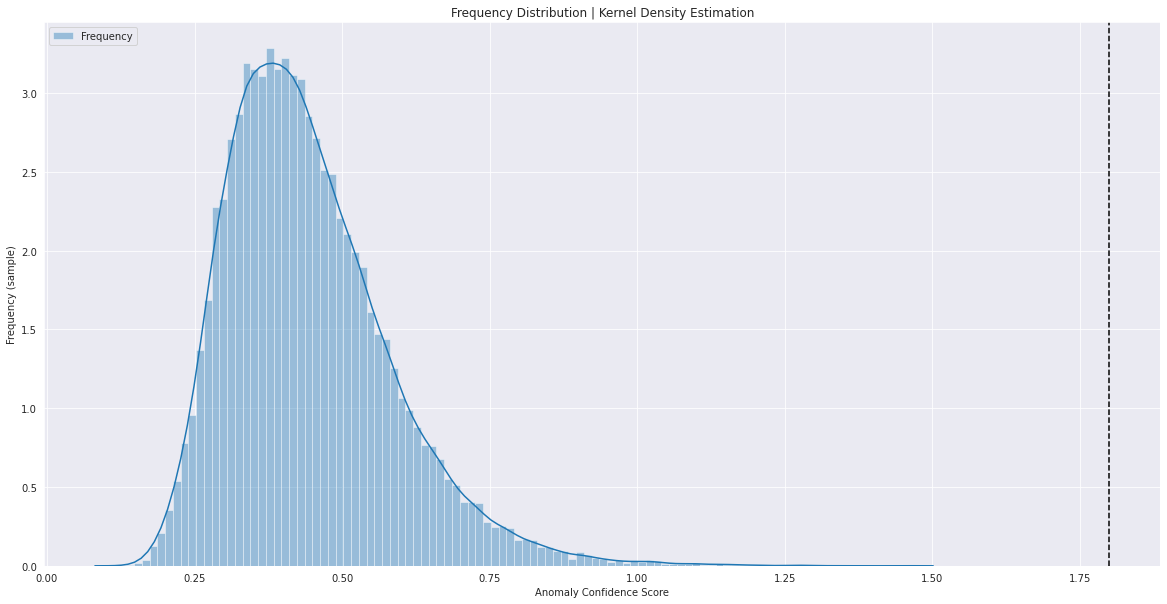

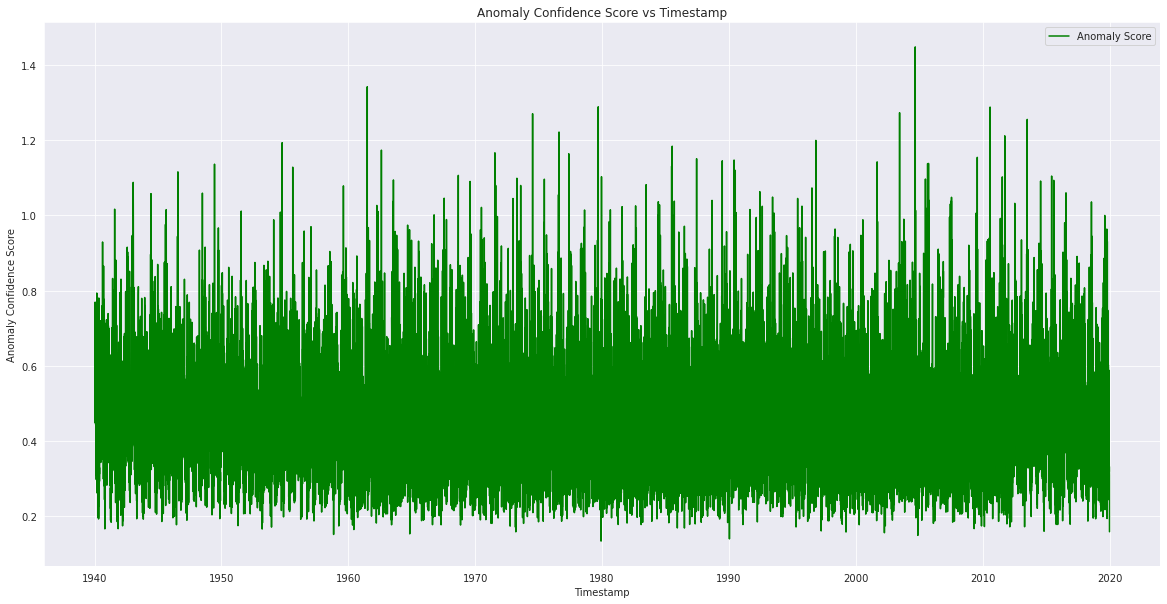

In [28]:
"""
    Visualization 
"""
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
ax = sns.distplot(loss_df["loss"], bins=100, label="Frequency")
ax.set_title("Frequency Distribution | Kernel Density Estimation")
ax.set(xlabel='Anomaly Confidence Score', ylabel='Frequency (sample)')
plt.axvline(1.80, color="k", linestyle="--")
plt.legend()

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="timestamp", y="loss", data=loss_df, color='g', label="Anomaly Score")
ax.set_title("Anomaly Confidence Score vs Timestamp")
ax.set(ylabel="Anomaly Confidence Score", xlabel="Timestamp")
plt.legend()